In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, patches
import matplotlib
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema, resample
from scipy.stats import describe
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

# Ignore some warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set graphing params.
sns.set()
matplotlib.rcParams['figure.figsize'] = (30.0, 10.0)

### Munging functions
These are helper functions. Columns are renamed to a standard format:

Header | Value    
   --- | --- 
f | Raw force (N)
mdia | Muscle diameter (in)
msgtype | N/A
pwm | Digital PWM value
rc | Constant
rw | Constant
t  | Temperature
t0 | Starting temperature
timestamp | Absolute time (s)

In [6]:
# Renames columns to standard format listed above,
# Normalizes timestamps relative to 0 (instead of experiment start time),
# Fills NaNs, inverts force.
def clean(df):
    df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
    if(df.iloc[0].timestamp > 0):
        df.timestamp -= df.iloc[0].timestamp
    df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
    df.f = -df.f
    return df.fillna(0)

In [7]:
# Grabs rolling average with default lag of 300-points.
# You can set #points in rolling window with `window` param, and
# select whether to add the rolling average column to the given 
# dataframe with `add_col` param.
def ma(df, window=500, add_col=True):
    m = df.f.rolling(window=window).mean()
    if add_col:
        df['f_ra'] = m
        return df.fillna(0)
    return m

In [8]:
# Grabs minima and maxima.
# This is its own function only because this is an expensive operation.
# Note this function operates on the rolling average, not the raw force, to prevent noisy points from interfering.
def get_extrema(df, order=2000, ra=False):
    col = 'f_ra' if ra else 'f'
    maxima = argrelextrema(df[col].values, np.greater, order=order)
    minima = argrelextrema(df[col].values, np.less, order=order)
    return minima, maxima

In [9]:
# Labels cycles based on local (force) minima and maxima.
# Points not belonging to a valid cycle, e.g. at start and end of experiment,
# are labeled with <cycle# = -1>.
def label_cycles(df, minima, maxima, abs_min=None, abs_max=None, plot_boxes=True):
    # Plot line connecting all minima, and another line connecting all maxima.
    fig, ax = plt.subplots(figsize=(25, 6), nrows=1, ncols=1)
    if abs_min and abs_max:
        ax.plot(df.f, alpha=0.3)
        ax.plot(df.f.iloc[abs_max[0].tolist()], '--')
        ax.plot(df.f.iloc[abs_min[0].tolist()], '--')

    # Label cycles.
    df['cycle'] = -1
    for i in range(minima[0].size-1):
        rng = list(range(minima[0][i], minima[0][i+1]))
        df.iloc[rng, df.columns.get_loc('cycle')] = i # I don't know why `iloc` succeeds while `loc` fails here. I spent 1.5 hours on this bug.
  
    # Draw bounding boxes around each cycle.
    if plot_boxes:
        for i in minima[0].tolist():
            ax.add_patch(
                patches.Rectangle((i, df.f.min()), df[df.cycle==i].shape[0], df.f.max()-df.f.min(), linewidth=1, edgecolor='black', facecolor='none', alpha=0.2, linestyle=':')
            )
    df.cycle = df.cycle.astype(np.int64) # Just to be safe
    return df

In [10]:
# Squashes periods down to a constant for all rows in a dataset.
# You can set the desired period with param `period`.
# If you don't, the function just chooses the shortest period.
def squash_periods(df, period=-1, plot_cycles=True):
    c_to_p = {} # maps cycles to their periods
    columns=["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp", "f_ra", "cycle"]
    fig, ax = plt.subplots(figsize=(25, 12), nrows=1, ncols=1)
    df.cycle, X = df.cycle.astype(np.int64), pd.DataFrame(columns=columns)
        
    for c in range(df.cycle.max()):
        c_to_p[c] = df[df.cycle==c].shape[0]
    if period<0:
        period = int(min(c_to_p.values()))

    for c in range(df.cycle.max()):
        C = pd.DataFrame(resample(df[df.cycle==c], period), columns=columns)
        C.cycle = c
        X = pd.concat([X, C], ignore_index=True)
        if plot_cycles:
            ax.plot(C.f_ra, color=plt.cm.RdYlBu(c/df.cycle.max()))
    X.timestamp = df.timestamp.iloc[:X.timestamp.size,]
    
    if plot_cycles:
        cmap = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=df.cycle.max()),
            cmap=plt.get_cmap('RdYlBu', df.cycle.max())
        )
        cmap.set_array([])
        plt.colorbar(cmap, orientation="horizontal", pad=0.1)
        
    return X, c_to_p

In [11]:
# Prints descriptive stats about a 1-D dataset.
# (Mean, stdev, first quartiles, and index of dispersion if `dispersion=True`).
def stats(series, dispersion=True):
    print("SUMMARY\n")
    if dispersion:
        mean, var = np.mean(series.values), np.var(series.values)
        print("index of dispersion\t%f\n%s" % (var/mean, '-'*50))
    print(series.describe(include='all'))

In [12]:
# Detrend a feature by simple differencing.
# Takes difference of each point by given lag (default=1 cycle, not 1 pt).
def difference(df, periods=None, cols_to_diff=['f', 't', 'f_ra']):
    if not periods:
        periods = df[df.cycle==1].size
    return df[cols_to_diff].diff(periods=periods).fillna(0)

In [13]:
# Detrend a feature using simple OLS regression.
# `x` = X-feature, should always be timestamp or index.
# `y` = feature to detrend, generally force.
# `order` = order of regression polynomial, default quadratic.
def reg_detrend(df, x='timestamp', y='f', order=2):
    reg, poly = LinearRegression(), PolynomialFeatures(order)
    X_t = poly.fit_transform(df[x].values.reshape(-1,1))
    reg.fit(X_t, df[y].values.reshape(-1,1))
    return reg.predict(X_t)

In [14]:
# Computes average force over all cycles in a dataset X, using detrended force feature.
# Returns a single cycle whose force characteristic is the average of all cycles'
# force values for this dataset.
def average(X):
    cycles, n = X.cycle.max(), X[X.cycle==1].shape[0]
    means = [sum(X.f_det.iloc[j::n])/cycles for j in range(n)]
    return means

In [15]:
# Compute power given PWM value, voltage source resistance, and muscle resistance.
# If `periods` is provided, then plot graph of cycle periods of time on same plot.
def power(pwm, R, r, periods=None):
    i = (pwm/255.0)/(R+r)
    P = i**2 * R
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Cycle #')
    ax1.set_ylabel('Power')
    ax1.plot(P)
    ax1.tick_params(axis='y')
    
    if periods.any():
        ax2 = ax1.twinx()
        ax2.set_ylabel('Period', color='r')
        ax2.plot(periods, color='r')
        ax2.tick_params(axis='y') #, labelcolor='r')
        return (ax1, ax2, fig)
    return P

# Datasets
We inspect trials from `11/06` and `11/16`. For `11/06`:

$$
d=1in\\
\textrm{Duty cycle}=150ms\\
f_{min}=5N\\
f_{max}=40N\\
R=27.5\Omega\\
T=4.5hrs\\
c=40
$$

The `11/16` trial is similar, but lasts for
$$
c=100
$$
possibly due to conductive paste in the silicon.

In [16]:
# X_25 is from a 3/4"(?) diameter muscle back in September.
X_25 = pd.DataFrame.from_dict(pd.read_msgpack("data/data_2018-09-25-14-24-26.msgpack"))
X_25.insert(1, "mdia", 0.75) # need to handle this missing column in this particular dataset.
X_25 = ma(clean(X_25))

In [17]:
# X_40 is a dataset with estimated 40 cycles.
X_40 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-11-06-22-59-57.msgpack"))))

In [18]:
# X_100 is a dataset with estimated 100 cycles and conductive paste in silicon skin.
X_100 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-11-16-21-07-24.msgpack"))), window=150)

In [19]:
# The only difference with these two tests is that they had half a tube of thermal paste in each muscle 
# vs the last muscle that had one tube for one muscle. -Cesar
# We got ~40 cycles in 2.5 hours (still an improvement from ~30 in 4 hours with no thermal paste). 
X_41 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-12-01-18-01-00.msgpack"))), window=150)

In [19]:
X_42 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-12-01-18-01-46.msgpack"))), window=150)

In [20]:
# This one has one tube of thermal paste for one muscle. 
# Ignore the temperature data, something went wrong with the sensor mid test. -Cesar
X_61_1 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-12-11-20-16-17.msgpack"))), window=150)

In [21]:
# Same parameters as above.
X_61_2 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-12-12-18-21-34.msgpack"))), window=150)

All datasets are stored in the `X_all` variable for brevity.
```python
X_all = [ my_dataset_0, ... , my_dataset_n ] # now just iterate over X_all
```

In [22]:
X_all = [ X_25, X_40, X_100, X_41, X_42, X_61_1, X_61_2 ]
titles = [
    '14 cycles, no thermal paste, d=0.75\"',\
    '36 cycles, no thermal paste, d=1.00\"',\
    '103 cycles, 100% thermal paste, d=1.00\"',\
    '32 cycles, 50% thermal paste, d=1.00\"',\
    '42 cycles, 50% thermal paste, d=1.00\"',\
    '61 cycles, 100% thermal paste, d=1.00\"',\
    '?? cycles, 100% thermal paste, d=1.00\"'
]

## Generate all plots for a given cycle

In [ ]:
def run(X, order=3000, thermal_paste_percentage=0):    
    # label cycles,
    # stationarize,
    # detrend,
    # denoise,
    
    # label cycles
    minima, maxima = get_extrema(X, ra=True) # n~=2000 is a safe order size for extrema: see next plot.
    abs_min, abs_max = get_extrema(X, order=order, ra=False)
    X, d = label_cycles(X, minima, maxima, abs_min=abs_min, abs_max=abs_max), X.mdia[0]
    
    X.cycle = X.cycle.astype(np.int64)
    X_S, c_to_p = squash_periods(X)
    X_S.cycle = X_S.cycle.astype(np.int64)
    n_cycles = X_S.cycle.max()
    
    # Label cycles; absolute max/min; moving-average max/min.
    fig, ax = plt.subplots(figsize=(30, 10))
    fig.title('%d cycles, %s thermal paste, d=%f"' % (n_cycles, str(thermal_paste_percentage)+'%', d))
    fig.xlabel('t (ms)')
    fig.ylabel('f (N)')
    fig.plot(X_40.f_ra)
    fig.plot(X_40.f_ra.iloc[minima], color='r', alpha=0.3)
    fig.plot(X_40.f_ra.iloc[maxima], color='g', alpha=0.3)

In [ ]:
run(X_40, thermal_paste_percentage=100)

## Fix stationarity (period).
Mean, variance, and autocorrelation of each cycle are not quite constant. We can't usefully determine correlation between variables until stationarity is maintained. We can eliminate stationarity by differencing data:
$$
Y_i = Z_i - Z_{i-1} \quad \forall i\in\big(0, \dots,T\big)
$$
or by fitting a trend and removing residuals:
$$
Y = a + bln\,X
$$
We'd also like to enforce constant period (and add our detrended period back in later) for robust regression:
$$
P_t = P_{t+1} \quad \forall t \in\big(0, (T-1)\big)
$$
First, adjust for seasonality.

### Fix `36`-cycle periods.
We analyze variance with index of dispersion (normalized to mean):
$$
D = \frac{\sigma^2}{\mu}
$$

## Detrend data.
by differencing:
$$
\Delta X_t = X_t - X_{t-1}
$$

and by regression. Pre-detrend:

After detrending:

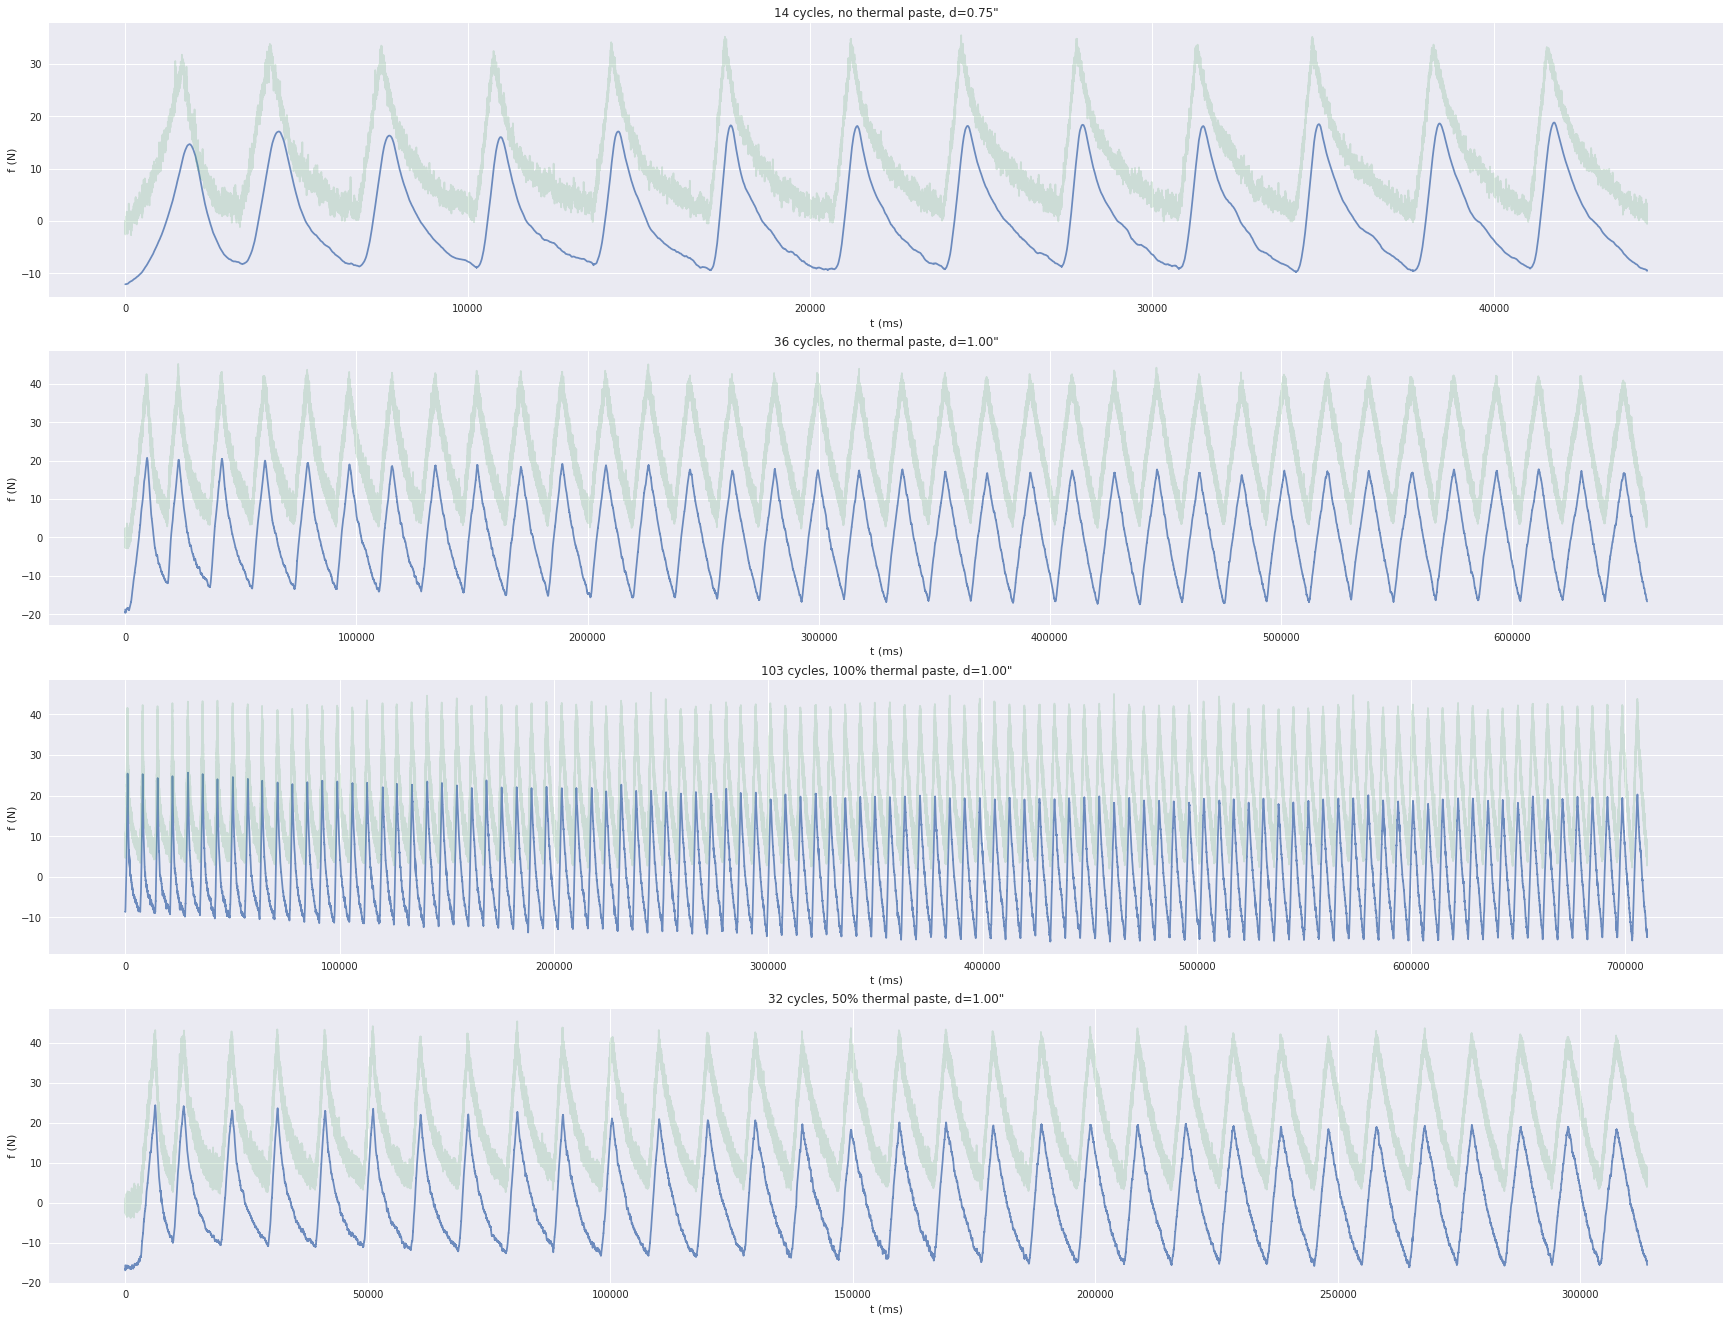

In [594]:
fig, ax = plt.subplots(figsize=(30, 20), nrows=4, ncols=1)
ax.flat[0].plot(X_25S.f_det, alpha=0.8); ax.flat[0].plot(X_25S.f, alpha=0.2); ax.flat[0].set_title('14 cycles, no thermal paste, d=0.75\"')
ax.flat[1].plot(X_40S.f_det, alpha=0.8); ax.flat[1].plot(X_40S.f, alpha=0.2); ax.flat[1].set_title('36 cycles, no thermal paste, d=1.00\"')
ax.flat[2].plot(X_100S.f_det, alpha=0.8); ax.flat[2].plot(X_100S.f, alpha=0.2); ax.flat[2].set_title('103 cycles, 100% thermal paste, d=1.00\"')
ax.flat[3].plot(X_41S.f_det, alpha=0.8); ax.flat[3].plot(X_41S.f, alpha=0.2); ax.flat[3].set_title('32 cycles, 50% thermal paste, d=1.00\"')
for axes in ax.flat:
    axes.set_xlabel('t (ms)')
    axes.set_ylabel('f (N)')
fig.subplots_adjust(top=1.0)

# Average seasonality.
Gives us a reasonably robust seasonal component, from which we can determine multiplicative noise. For stationary cycle (rising edge to rising edge) in $n$ discrete time chunks, this is simply
$$
\begin{matrix}
\mathop{\mathbb{E}}[f_{t_0}] \\
\vdots \\
\mathbb{E}[f_{t_n}]
\end{matrix}
$$

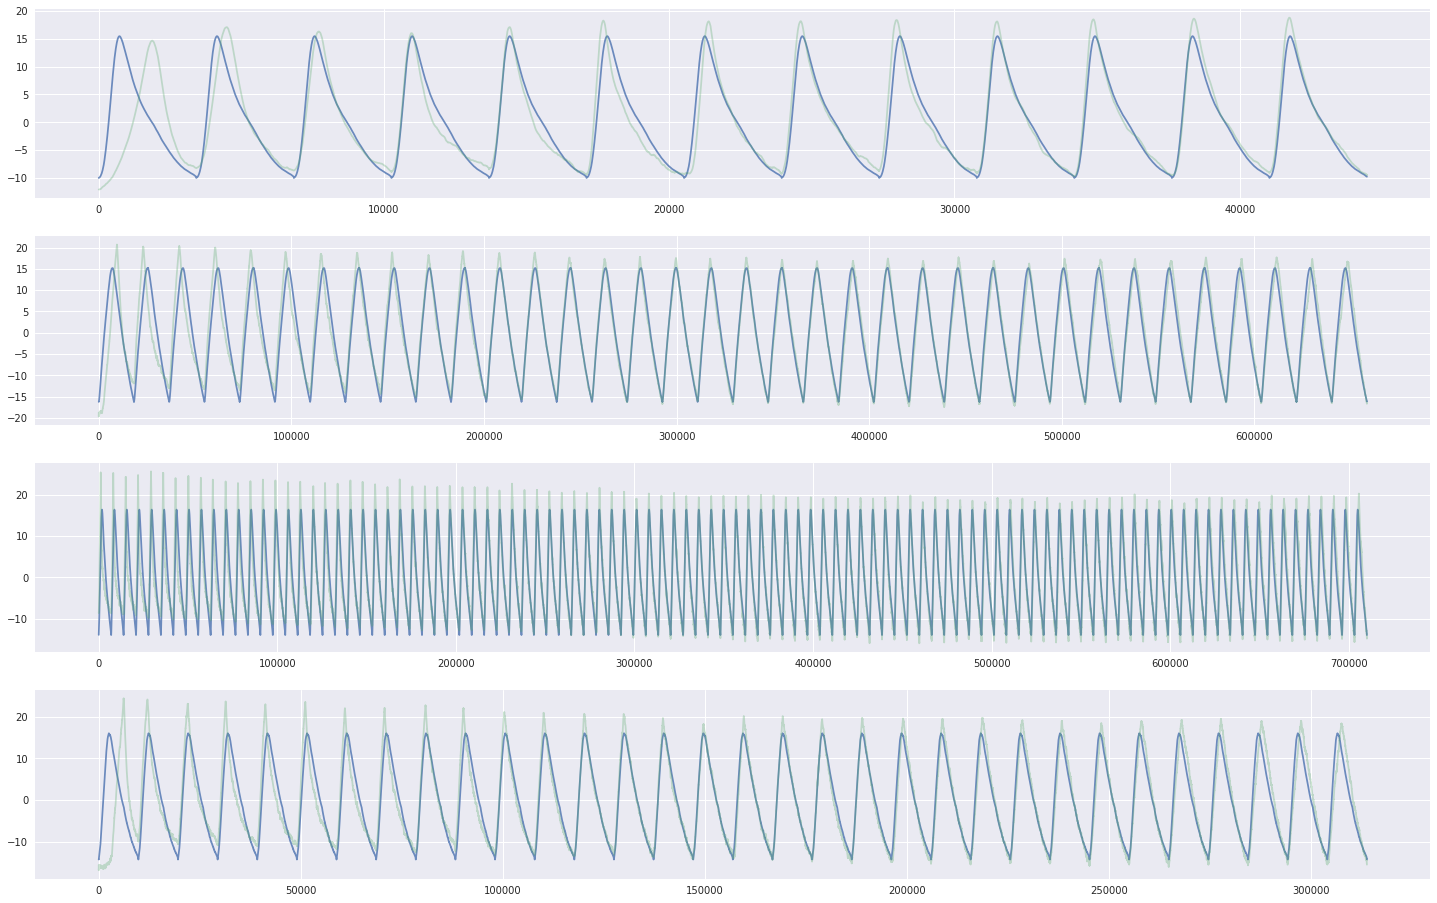

In [242]:
fig, ax = plt.subplots(figsize=(25, 16), nrows=4, ncols=1)
for i, X in enumerate([X_25S, X_40S, X_100S, X_41S]):
    ax.flat[i].plot(average(X) * (X.cycle.max()+1), alpha=0.8); ax.flat[i].plot(X.f_det, alpha=0.3)

## Noise component (period independent)
Period not returned yet / still some seasonality in this noise

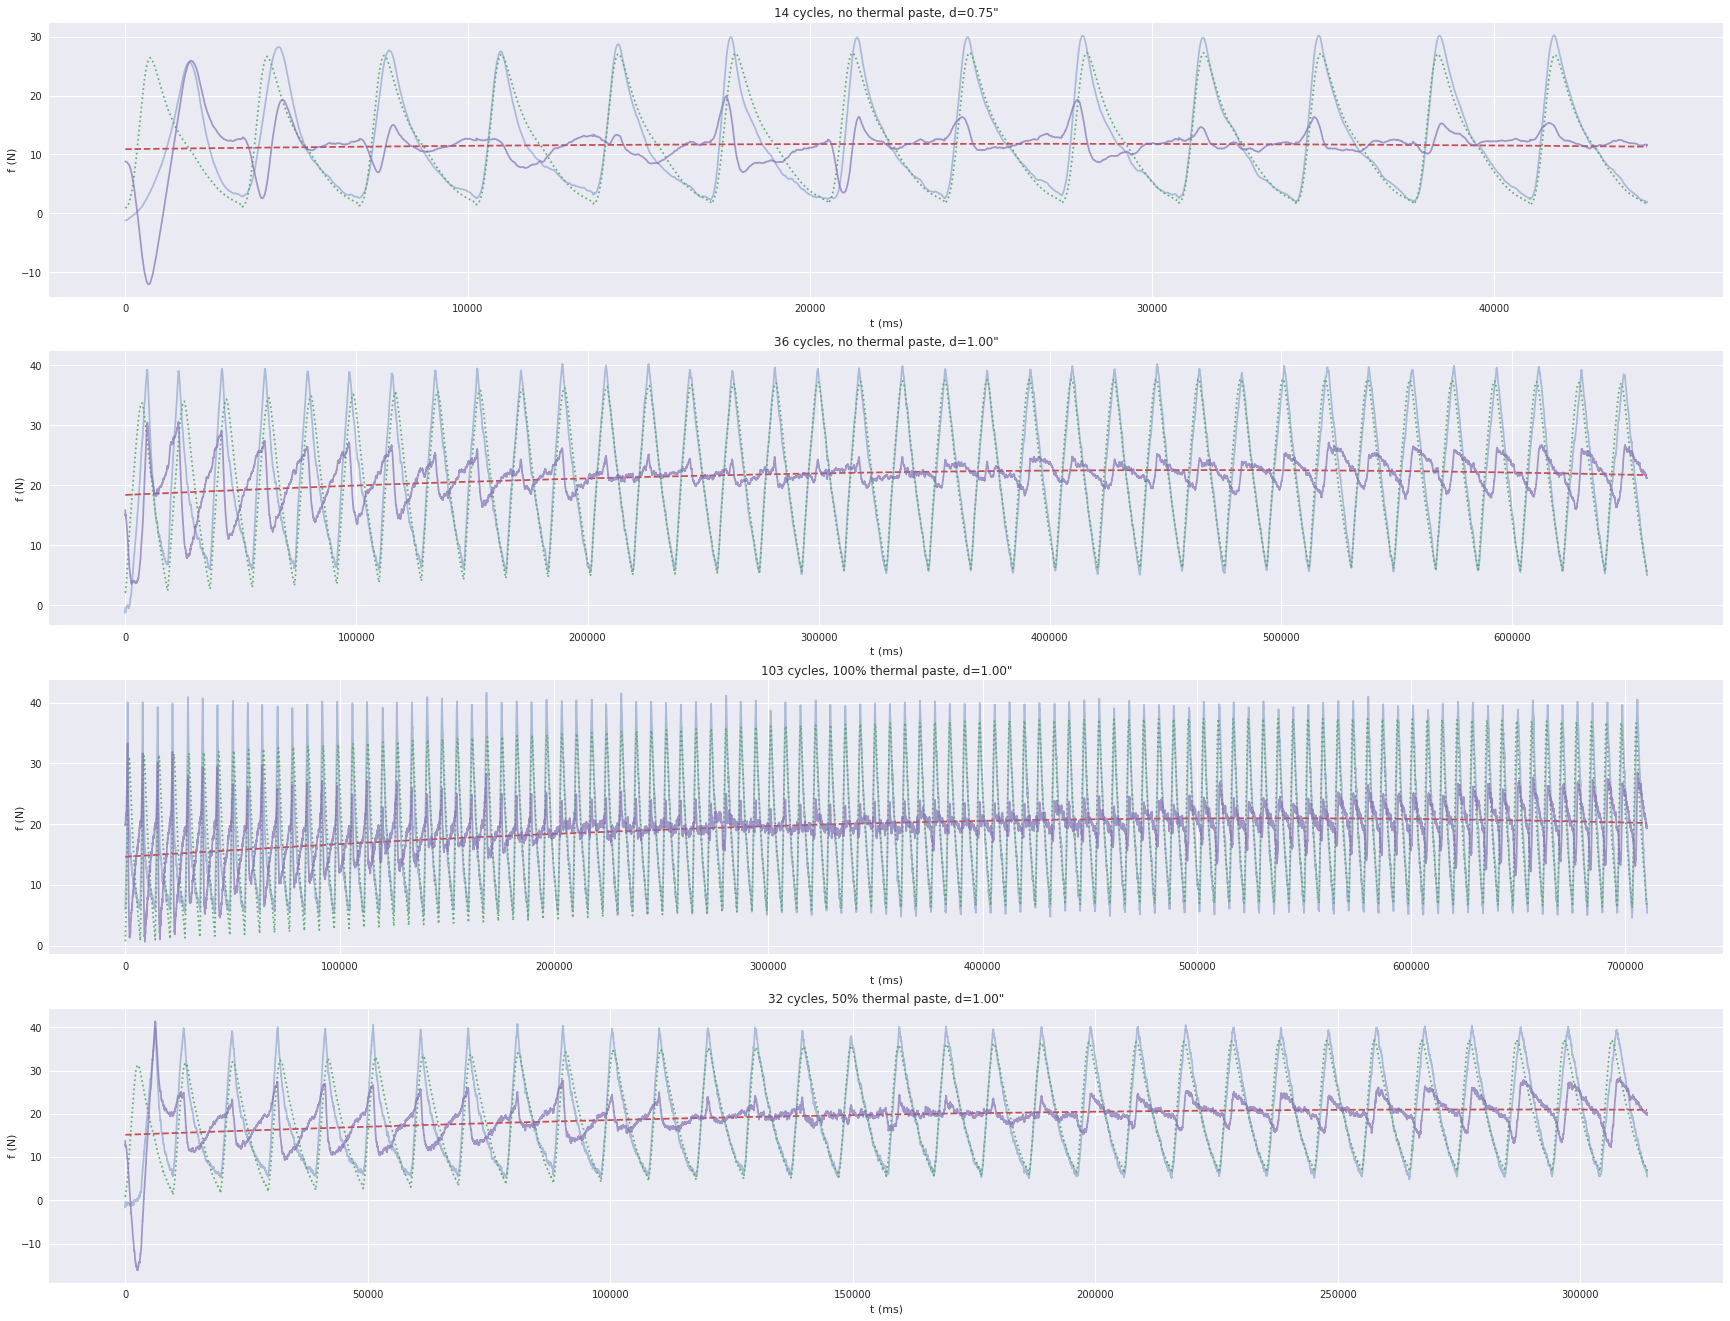

In [596]:
fig, ax = plt.subplots(figsize=(30, 20), nrows=4, ncols=1)
for i, Xr in enumerate([(X_25S, reg_25), (X_40S, reg_40), (X_100S, reg_100), (X_41S, reg_41)]):
    seasonal = average(Xr[0]) * (Xr[0].cycle.max()+1)
    ax.flat[i].plot(Xr[0].f_ra, alpha=0.4)
    ax.flat[i].plot(seasonal + Xr[1], ':', alpha=0.9)
    ax.flat[i].plot(Xr[1], '--')
    ax.flat[i].plot(Xr[0].f_ra - seasonal, alpha=0.7)

ax.flat[0].set_title('14 cycles, no thermal paste, d=0.75\"')
ax.flat[1].set_title('36 cycles, no thermal paste, d=1.00\"')
ax.flat[2].set_title('103 cycles, 100% thermal paste, d=1.00\"')
ax.flat[3].set_title('32 cycles, 50% thermal paste, d=1.00\"')
for axes in ax.flat:
    axes.set_xlabel('t (ms)')
    axes.set_ylabel('f (N)')
fig.subplots_adjust(top=1.0)

Noise component (period dependent?)

# PWM response.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fac6b3d10b8>,
 <matplotlib.figure.Figure at 0x7fac5d6719b0>)

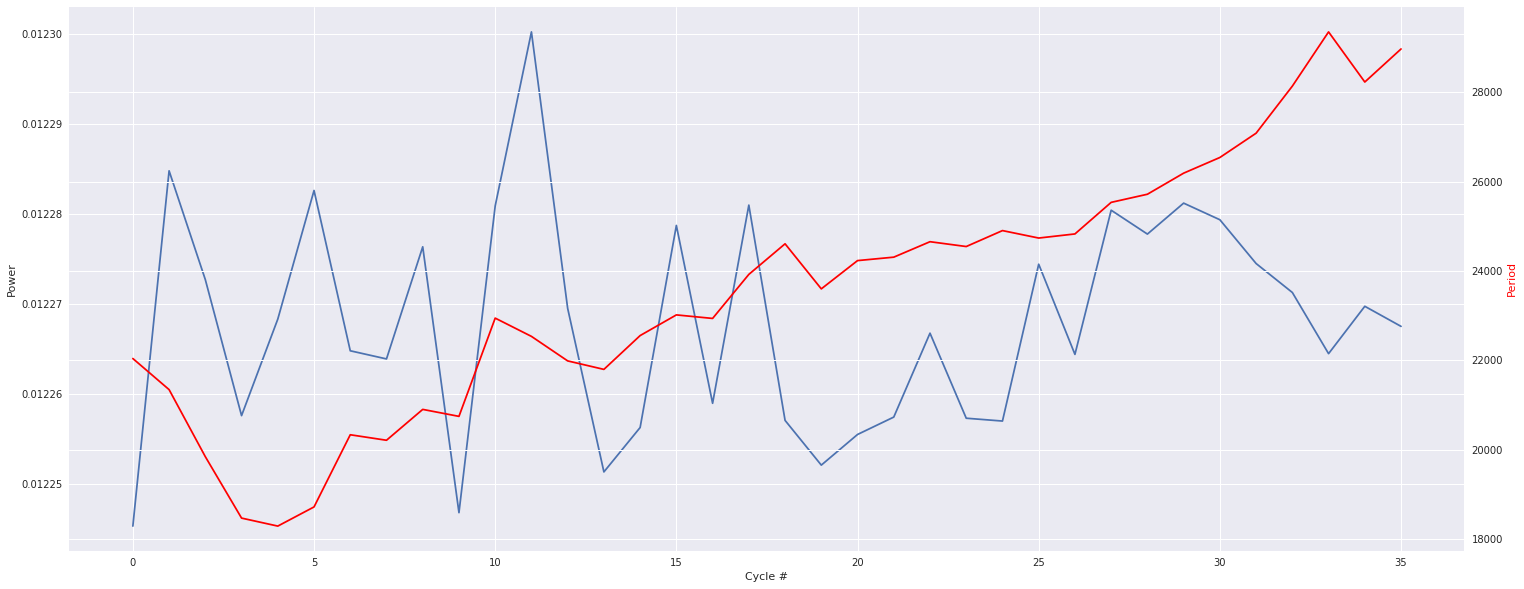

In [322]:
pwm = X_40S.pwm.iloc[::(X_40S[X_40S.cycle==1].shape[0])].values
power(pwm, X_40S.rc.iloc[0], X_40S.rw.iloc[0], np.asarray(list(c_to_p40.values())))

## Temperatures. 

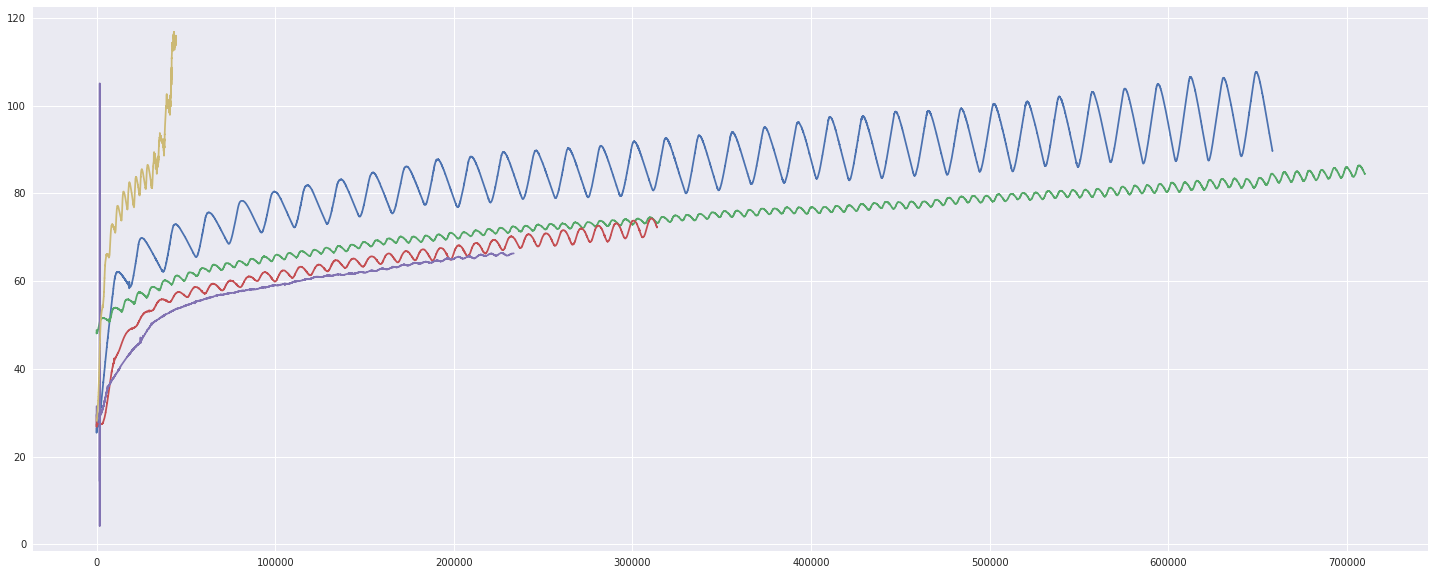

In [395]:
plt.plot(X_40S.t)
plt.plot(X_100S.t)
plt.plot(X_41S.t)
plt.plot(X_42S.t)
plt.plot(X_25S.t)

### Covariance between PWM/temp/force

## Force response given PWM, current (relative) temperature
First, fit periods.

In [364]:
for i in range(5):
    if i in c_to_p42.keys():
        del c_to_p42[i]

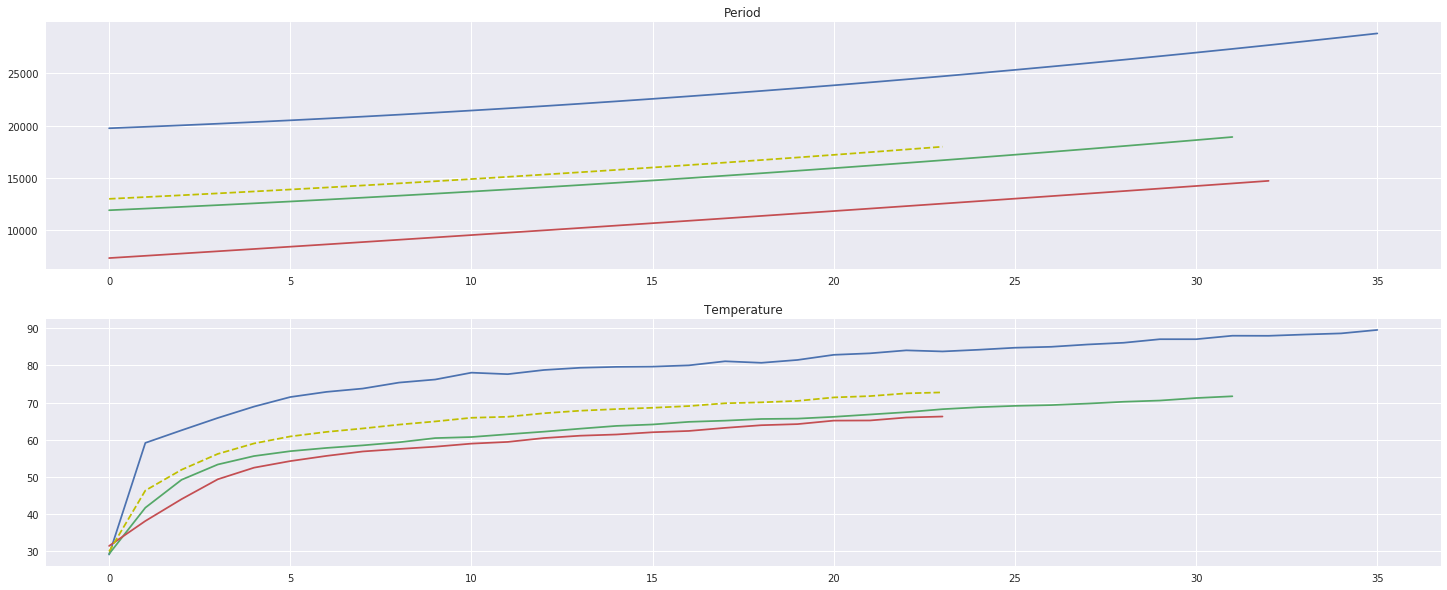

In [441]:
fig, ax = plt.subplots(figsize=(25, 10), nrows=2, ncols=1)
period_trend = []
ax.flat[0].set_title('Period duration')

p_mean = []
ax.flat[0].set_title('Period')
for mapping in [c_to_p40, c_to_p41, c_to_p42]:
    X = pd.DataFrame(data=np.asarray(list(mapping.values())), 
                     index=np.arange(len(mapping.keys()))
                    ).reset_index()
    X.columns = ['cycle', 'period']
    p_mean.append(reg_detrend(X, x='cycle', y='period', order=2))
    ax.flat[0].plot(p_mean[-1])

p_mean = sum([np.asarray(p[:24]) for p in p_mean])/3
ax.flat[0].plot(p_mean, '--', c='y')

ax.flat[1].set_title('Temperature')
t_40down, t_41down, t_42down = X_40S.t.iloc[::(X_40S[X_40S.cycle==1].shape[0])].values,\
    X_41S.t.iloc[::(X_41S[X_41S.cycle==1].shape[0])].values,\
    X_42S.t.iloc[::(X_41S[X_41S.cycle==1].shape[0])].values
t_mean = (t_40down[:24] + t_41down[:24] + t_42down[:24])/3

for td in [t_40down, t_41down, t_42down]:
    ax.flat[1].plot(td)
ax.flat[1].plot(t_mean, '--', c='y')

Regress on temperature (wrt `0`) to get estimated period.

In [549]:
reg, poly = LinearRegression(), PolynomialFeatures(3)
X_t = poly.fit_transform(t_mean.reshape(-1,1))
reg.fit(X_t, p_mean.reshape(-1,1))
p_est = reg.predict(X_t)

In [565]:
def func(x, a, b, c, d):
    return a * np.exp(-b * (x - c)) + d

init_vals = [1,0,1,1]
# fit your data and getting fit parameters
popt, pcov = curve_fit(func, t_mean, p_mean.transpose()[0], p0=init_vals)

In [566]:
popt, pcov

(array([ 4.76581470e-03, -1.35052909e-01, -3.01263551e+01,  1.29265085e+04]),
 array([[ 3.53987659e+06, -2.30032308e+00,  5.49980345e+09,
         -1.81387074e+04],
        [-2.30032296e+00,  2.74653212e-05, -3.57396491e+03,
         -2.84385385e-01],
        [ 5.49980345e+09, -3.57396509e+03,  8.54488489e+12,
         -2.81813518e+07],
        [-1.81387095e+04, -2.84385383e-01, -2.81813549e+07,
          5.16896986e+03]]))

Resample mean cycle and add trend, noise components.

In [468]:
def res_mean(t, reg, poly):
    res = resample(average(X_40S), 
                   int(reg.predict(poly.fit_transform(np.asarray([t]).reshape(-1,1)))[0][0]))
    return res

In [474]:
X = np.arange(int(reg.predict(poly.fit_transform(np.asarray([50]).reshape(-1,1)))[0][0]))
y = res_mean(50, reg, poly)

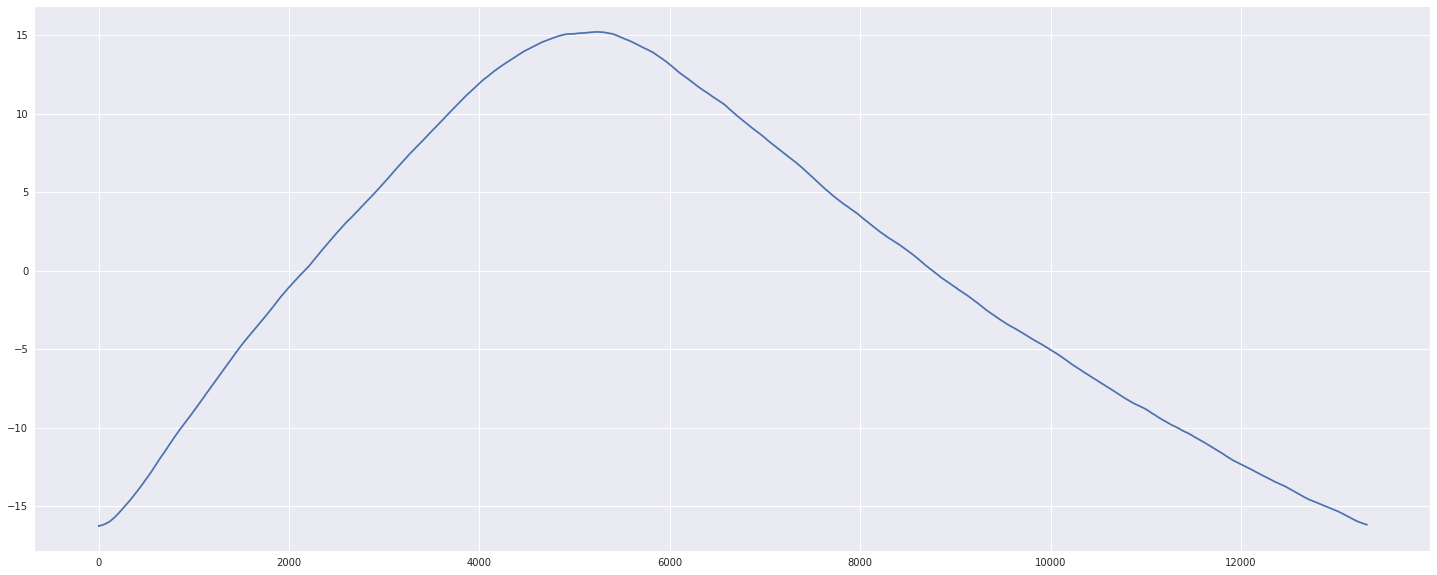

In [475]:
plt.plot(y)

In [622]:
z = np.poly1d(np.polyfit(X,y,9))
#z = np.polyfit(X, np.log(y), 4)

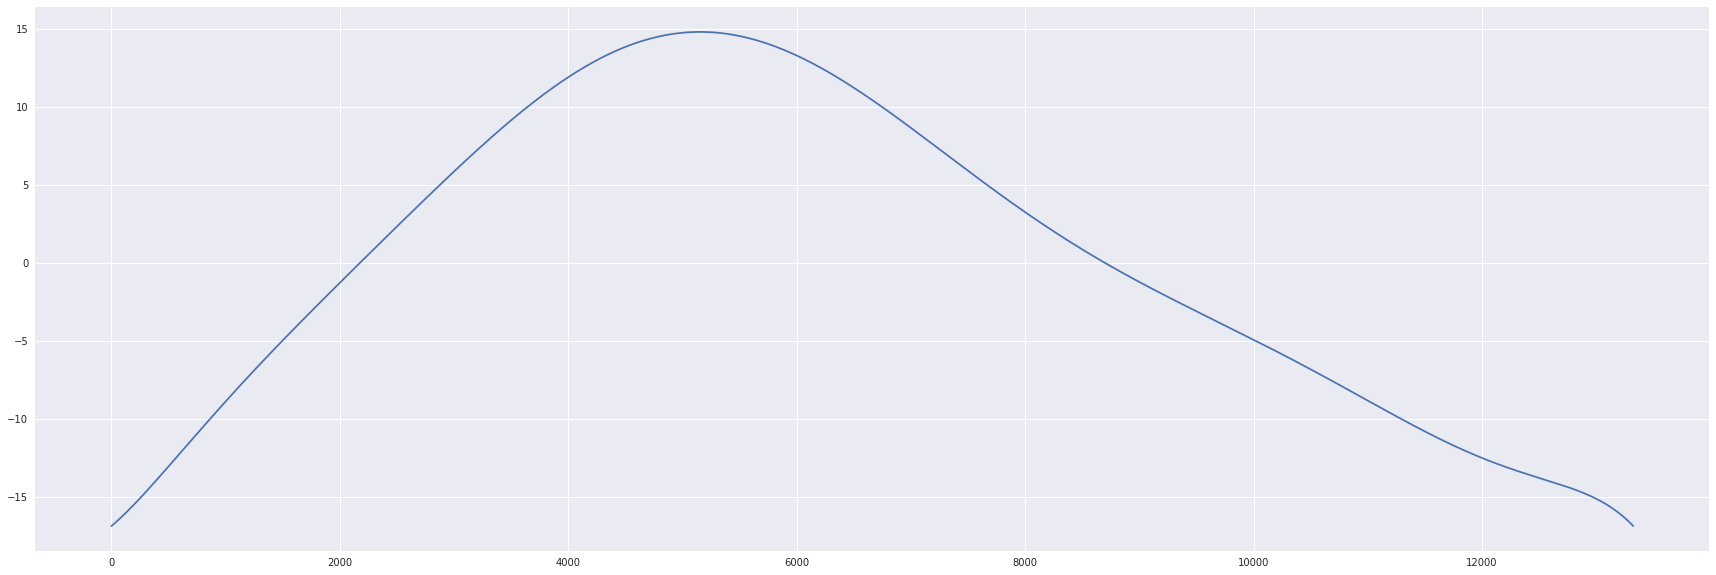

In [623]:
plt.plot(z(X))

In [529]:
z.c

array([-3.55911835e-44,  2.87189539e-39, -1.00799641e-34,  2.01298928e-30,
       -2.50960774e-26,  2.01396643e-22, -1.03258205e-18,  3.22908865e-15,
       -5.47879448e-12,  3.23252519e-09,  2.39281848e-06,  5.07802952e-03,
       -1.65278812e+01])

In [539]:
np.polyfit(X, np.log(y+y.min()+1), 1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([nan, nan])

In [542]:
curve_fit(lambda t,a,b: a*np.exp(b*t),  X,  y, p0=(1, 1))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/home/nwchen/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:744: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1., 1.]), array([[inf, inf],
        [inf, inf]]))

water actuator? (no blocked force apparatus...)
ethanol leakage - quantifiable?
different in ambient vs. internal temperature?

continuous (not discrete-ish) pwm control

## Cyclic temperature
and correlation with force.

Could pre-heating muscle increase longevity?

## Muscle linearity**
(viability as an actuator)

Compare power response (wrt rc, rw, pwm) of 36-c vs 103-c datasets (R+r not constant, PWM varies, everything else held constant)

# Other questions
PWM response linearity?

Get response from PWM input